In [ ]:
import pandas as pd
import numpy as np
from seaborn import heatmap,scatterplot,lmplot,lineplot
from matplotlib.pyplot import figure, xlabel,ylabel,scatter,show,legend, title
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
df=pd.read_csv("Clientes_ns.csv", sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        200 non-null    int64 
 1   Sexo      200 non-null    object
 2   Edad      200 non-null    int64 
 3   Ingresos  200 non-null    int64 
 4   Score     200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
print(df.nunique().sort_values(ascending=False))
print("\nnulos\n ", df.isnull().sum())
print("\nduplicados ",df.duplicated().sum())

ID          200
Score        84
Ingresos     64
Edad         51
Sexo          2
dtype: int64

nulos
  ID          0
Sexo        0
Edad        0
Ingresos    0
Score       0
dtype: int64

duplicados  0


<Axes: xlabel='Ingresos'>

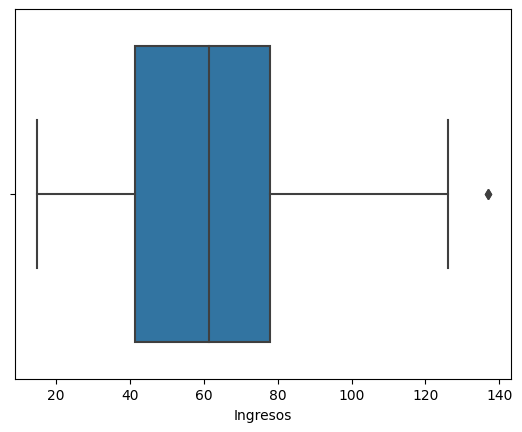

In [ ]:
#Analizando presencia de valores atípicos 
from seaborn import boxplot
boxplot(data=df, x="Ingresos") #se observan pocos outliers




<Axes: xlabel='Score'>

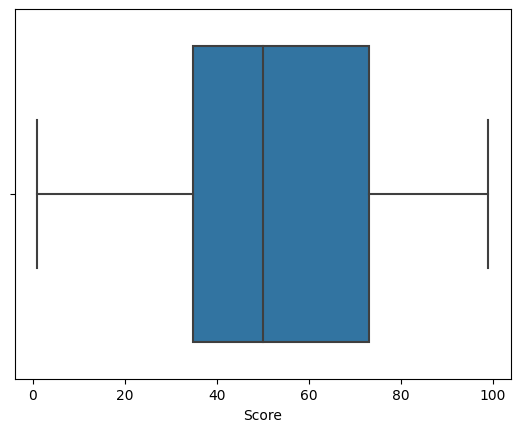

In [ ]:
boxplot(data=df, x="Score")

In [ ]:
print(df.Ingresos.describe())#La media y la mediana son casi iguales, hay muy pocos outiers
print("\n ")
print(df.Score.describe())#La mediana y la media son iguales, no deberian haber outliers


count    200.000000
mean      60.560000
std       26.264721
min       15.000000
25%       41.500000
50%       61.500000
75%       78.000000
max      137.000000
Name: Ingresos, dtype: float64

 
count    200.000000
mean      50.200000
std       25.823522
min        1.000000
25%       34.750000
50%       50.000000
75%       73.000000
max       99.000000
Name: Score, dtype: float64


In [ ]:
#Analizando presencia de valores atípicos 
features=["Ingresos","Score"]
def outliers_count(df,feature):

 def outliers_indexes(feature):
  Q1=np.percentile(feature,25)
  Q3=np.percentile(feature,75)
  IQR=Q3-Q1 #RANGO INTERCUARTIL
  whisker_width=1.5 
  threshold_low=Q1-(IQR*whisker_width)
  threshold_upper=(Q3+IQR*whisker_width)
  indexes=[index for index,value in feature.items() if ((value < threshold_low) or (value > threshold_upper))]
  return indexes
 indexes=outliers_indexes(df[feature])
 return len(indexes), indexes

index_=0
for f in features:
    print('\n' + f + ':\n')
    outliers_,index_=outliers_count(df,f)
    print("Cantidad de Ouliers: ", outliers_)
    #eliminando los outliers
    df.drop(index_,inplace=True)






Ingresos:

Cantidad de Ouliers:  2

Score:

Cantidad de Ouliers:  0


<Axes: xlabel='Ingresos'>

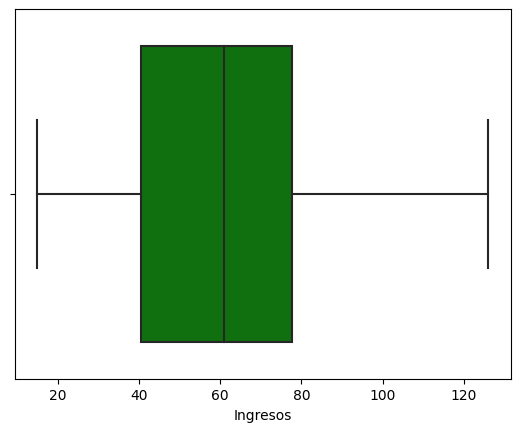

In [ ]:
boxplot(data=df, x="Ingresos", color="green") #ya no se observan outliers

<Axes: >

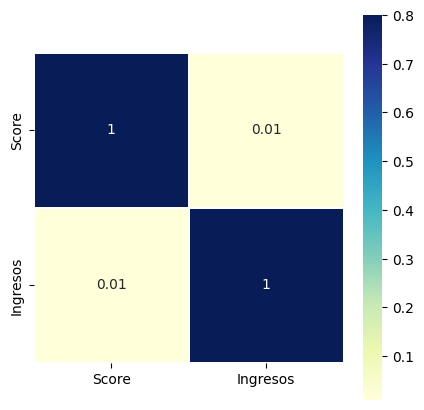

In [ ]:
#determinando si hay una relación lineal entre las variables

figure(figsize=(5,5))
heatmap(df[["Score","Ingresos"]].corr(),vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")

<Axes: xlabel='Score', ylabel='Ingresos'>

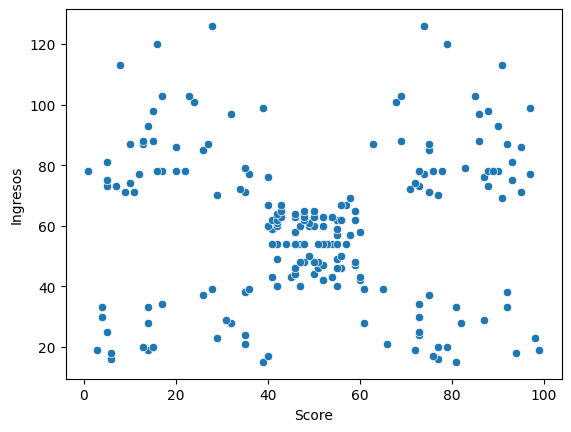

In [ ]:
scatterplot(data=df, x="Score", y="Ingresos") #No se observa una relación lineal entre ambas variables

In [ ]:
#Al tener una relación No lineal, DBSCAN sería una mejor opción al basarse en las densidades y no distancias, sin embargo, se ejecutará Kmeans y DBSCAN, para poder compararlos.
"""Aplicando Kmeans"""
df_num_kmean=df.loc[:,["Ingresos","Score"]].copy()
col=df_num_kmean.columns
#estandarización
se=StandardScaler()
df_num_kmean=pd.DataFrame(se.fit_transform(df_num_kmean), columns=col)
print(df_num_kmean.describe())


         Ingresos         Score
count  198.000000  1.980000e+02
mean     0.000000  1.104616e-16
std      1.002535  1.002535e+00
min     -1.779171 -1.915640e+00
25%     -0.766199 -5.917421e-01
50%      0.048151 -7.669638e-03
75%      0.713534  8.781735e-01
max      2.630236  1.900300e+00


'\ncodo: 5\nsilueta: 5\ncalins: 10\nDos de las dos métricas me indican 5 clusters, razón por la cual escogeré 5 clusters\n'

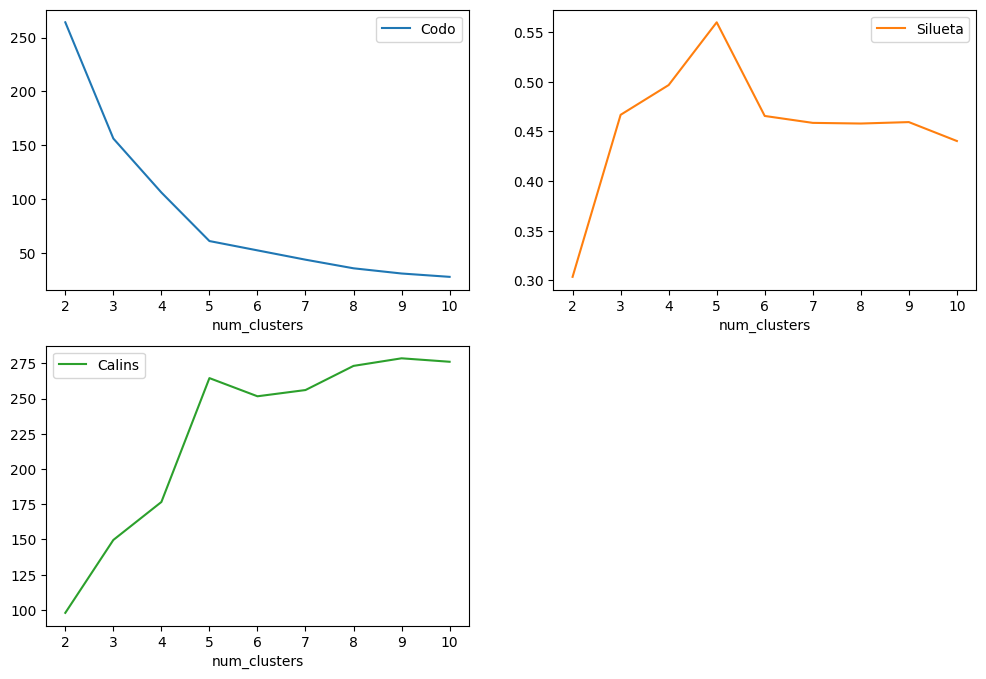

In [ ]:
# Creando el espacio de soluciones
clusters_posible=range(2,11) 
codo = []
silueta = []
calins = []

#probando las posibles soluciones
for cp in clusters_posible:
  #Instanciando
  cluster=KMeans(n_clusters=cp, n_init=10, random_state=1)
  #Entrenando
  cluster.fit(df_num_kmean)
  #obteniendo las metricas
  codo.append(cluster.inertia_)
  silueta.append(silhouette_score(df_num_kmean, cluster.labels_))
  calins.append(calinski_harabasz_score(df_num_kmean, cluster.labels_))

metricas = pd.DataFrame({'num_clusters':clusters_posible,
              'Codo': codo,
              'Silueta':silueta,
              'Calins':calins}).set_index('num_clusters')
metricas.plot(subplots = True, figsize = (12,8), layout = (2,2), sharex = False)
#Se observa:
"""
codo: 5
silueta: 5
calins: 10
Dos de las dos métricas me indican 5 clusters, razón por la cual escogeré 5 clusters
"""

In [ ]:
#instanciando
cluster=KMeans(n_clusters=5, n_init=10, random_state=1)
#entrenando
cluster.fit(df_num_kmean)
df["Cluster_Kmeans"]=cluster.predict(df_num_kmean)#Creo una nueva columna con los clusters en el dataframe original
print(df.groupby(["Cluster_Kmeans"]).agg({"Sexo":"value_counts"}))
print("\n\n")
print(df.groupby(["Cluster_Kmeans"]).agg({"Sexo":"count","Ingresos":"mean","Score":"mean","Edad":"mean"}))
#se observan 5 clústers

                       Sexo
Cluster_Kmeans Sexo        
0              Female    13
               Male       9
1              Male      18
               Female    17
2              Female    47
               Male      33
3              Female    14
               Male       9
4              Female    21
               Male      17



                Sexo   Ingresos      Score       Edad
Cluster_Kmeans                                       
0                 22  25.727273  79.363636  25.272727
1                 35  86.342857  17.571429  40.914286
2                 80  55.087500  49.712500  42.937500
3                 23  26.304348  20.913043  45.217391
4                 38  85.210526  82.105263  32.763158


In [ ]:
"""APLICANDO DBSCAN"""
df_num_dbscan=df.loc[:,["Ingresos","Score"]].copy()
#Estandarizando
sc_=StandardScaler()
df_num_dbscan=pd.DataFrame(sc_.fit_transform(df_num_dbscan), columns=col)
df_num_dbscan.describe()

,Ingresos,Score
count,198.000000,1.980000e+02
mean,0.000000,1.104616e-16
std,1.002535,1.002535e+00
min,-1.779171,-1.915640e+00
25%,-0.766199,-5.917421e-01
50%,0.048151,-7.669638e-03
75%,0.713534,8.781735e-01
max,2.630236,1.900300e+00


0.105701001942902


Text(0, 0.5, 'Distance')

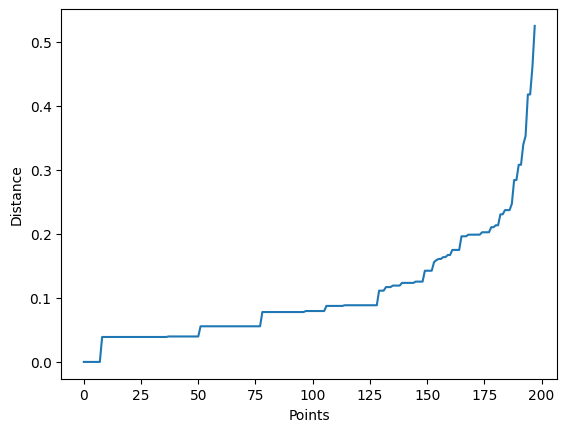

In [ ]:
#identificando el epsilón con Knn
from sklearn.neighbors import NearestNeighbors
k=3
nearest_neigbors=NearestNeighbors(n_neighbors=k)
neighbors=nearest_neigbors.fit(df_num_dbscan)
distances, indexes = neighbors.kneighbors(df_num_dbscan)
distances=np.sort(distances, axis=0)

#gráfico
distances = distances[:,1]

print(distances.mean())
i=np.arange(len(distances))
lineplot(x=i, y=distances)
xlabel("Points")
ylabel("Distance")

#epsilón=0.25

In [ ]:
#aplicando Dbscan
dbscan=DBSCAN(min_samples=k, eps=0.35).fit(df_num_dbscan)
labels=dbscan.labels_
df["Cluster_Dbscan"]=labels
df.head()
df["Cluster_Dbscan"].unique()
#Se observan 7 clústers

array([ 0,  1,  2,  3,  4,  5,  6, -1])

<Figure size 1200x1000 with 0 Axes>

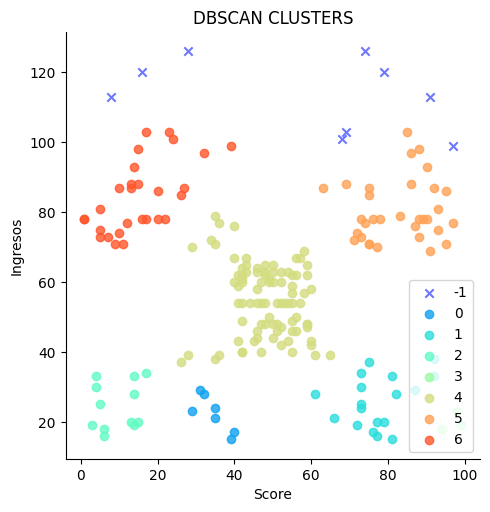

number of noise(s):  9


In [ ]:
#Gráficando los clústers de DBSCAN
figure(figsize=(12,10))
lmplot( x="Score", y="Ingresos", data=df, fit_reg=False, hue='Cluster_Dbscan', legend=False, palette="rainbow",markers=["x","o","o","o","o","o","o","o"])
# Move the legend to an empty part of the plot
legend(loc='lower right')
title("DBSCAN CLUSTERS")
show()

n_noise_ = list(labels).count(-1)
print('number of noise(s): ', n_noise_)

<Figure size 1200x1000 with 0 Axes>

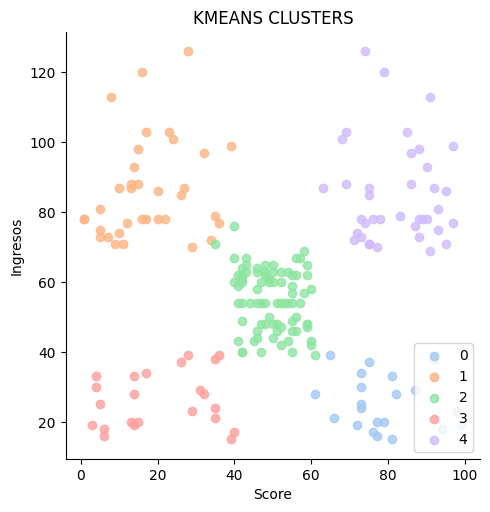

number of noise(s):  9


In [ ]:
#Gráficando los clústers de KMEANS 
figure(figsize=(12,10))
lmplot( x="Score", y="Ingresos", data=df, fit_reg=False, hue='Cluster_Kmeans', legend=False, palette="pastel",markers=["o","o","o","o","o"])
# Move the legend to an empty part of the plot
legend(loc='lower right')
title("KMEANS CLUSTERS")
show()

n_noise_ = list(labels).count(-1)
print('number of noise(s): ', n_noise_)

In [ ]:
#Tipificando Haciendo uso de los Clusters resultantes de Kmeans
"""
Pur:Purchase
Inc:Incomes
Med:Medium
"""
names={1:"Few_Pur&High_Inc",0:"High_Pur&Low_Inc",2:"Med_Pur&Med_Inc",3:"Few_Pur&Few_Inc",4:"High_Pur&High_Inc"}
df.Cluster_Kmeans=df.Cluster_Kmeans.map(names)
df.drop("Cluster_Dbscan",axis=1,inplace=True)

<Figure size 2000x2000 with 0 Axes>

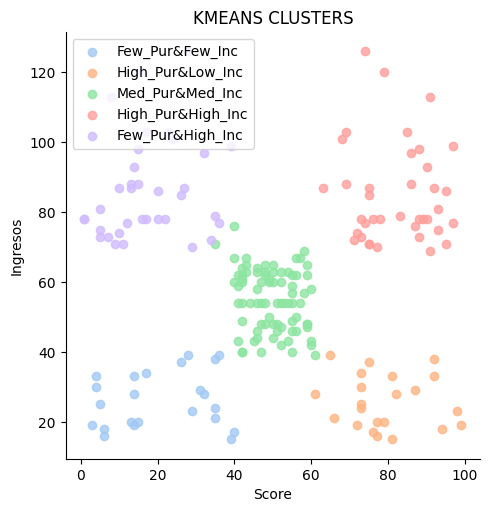

In [ ]:
figure(figsize=(20,20))
lmplot( x="Score", y="Ingresos", data=df, fit_reg=False, hue='Cluster_Kmeans', legend=False, palette="pastel",markers=["o","o","o","o","o"])
# Move the legend to an empty part of the plot
legend(loc='upper left')
title("KMEANS CLUSTERS")
show()



In [ ]:
#Analizando cada uno de los grupos
df.groupby(['Cluster_Kmeans','Sexo']).agg({"Edad":["count","mean"],
                         'Ingresos':'mean',
                         'Score':'mean'})



Edad              Ingresos      Score
                         count       mean       mean       mean
Cluster_Kmeans    Sexo                                         
Few_Pur&Few_Inc   Female    14  43.214286  27.357143  21.714286
                  Male       9  48.333333  24.666667  19.666667
Few_Pur&High_Inc  Female    17  42.176471  89.823529  22.764706
                  Male      18  39.722222  83.055556  12.666667
High_Pur&High_Inc Female    21  32.190476  86.047619  81.666667
                  Male      17  33.470588  84.176471  82.647059
High_Pur&Low_Inc  Female    13  25.461538  25.692308  80.538462
                  Male       9  25.000000  25.777778  77.666667
Med_Pur&Med_Inc   Female    47  41.234043  55.000000  49.319149
                  Male      33  45.363636  55.212121  50.272727

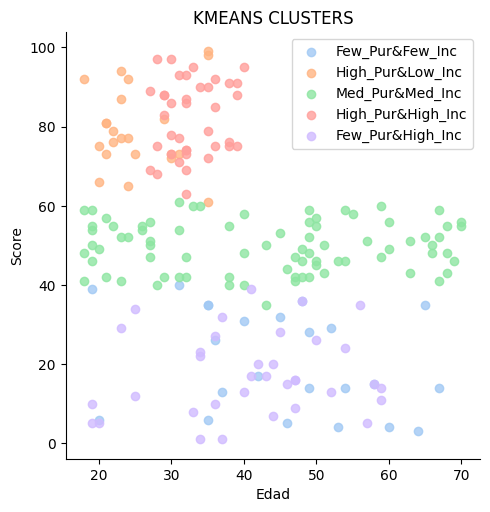

In [ ]:
lmplot( x="Edad", y="Score", data=df, fit_reg=False, hue='Cluster_Kmeans', legend=False, palette="pastel",markers=["o","o","o","o","o"])
# Move the legend to an empty part of the plot
legend(loc='upper right')
title("KMEANS CLUSTERS")
show()

In [ ]:
###################################Conclusiones################################
"""
1). Cluster Few_Pur&High_Inc:
Son los compradores que compran poco, a pesar de que tienen altos ingresos, es el grupo en que hay más equidad en cuanto a la cantidad de hombres y mujeres, con edades medias de 42 y 40 respectivamente. Este debería ser el 
cluster en el que más hay que invertir para lograr su interés en las compras, debido a los altos ingresos que perciben, con el objetivo que los miembros se desplacen el grupo "ideal" (High_Pur&High_Inc).

2). Cluster Few_Pur&Few_Inc:
Son los compradores que compran poco y poseen bajos ingresos, mayoritariamente son mujeres y las edades medias son de 43 (mujeres) y 48 (hombres). Debido a los bajos ingresos que perciben, no deberían ser de tanto interés.

3). Cluster High_Pur&High_Inc:
Compradores que compran mucho y tienen altos ingresos, mayoritariamente mujeres, y las edades medias son de 32 y 33 años. A este cluster, la estregia implementada debe tener el objetivo de mantener su interés por las compras, 
siendo este el grupo ideal.

4). Cluster High_Pur&Low_Inc:
Compradores que compran mucho, a pesar de que tienen bajos ingresos. En su mayoria son mujeres, con una edad media de 25 años, por ende son el grupo más jóven de todos. Este comportamiento es preocupante, puesto que se asocia
a una mala administración del dinero.

5). Cluster Med_Pur&Med_Inc:
Este Cluster es el que le sigue al grupo ideal (High_Pur&High_Inc). Es el grupo mayoritario, y en el abundan las mujeres, las edades medias son de 47(mujeres) y 33(Hombres) años. Quiza no sea el grupo de mayor interés ya que no 
perciben los mayores ingresos, pero es el más cuantioso lo que le da cierto grado de importancia, razón por la cual las estrategias deben estar orientadas solo a mantener su interés por las compras.
"""

'\n1). Cluster Few_Pur&High_Inc:\nSon los compradores que compran poco, a pesar de que tienen altos ingresos, es el grupo en que hay más equidad en cuanto a la cantidad de hombres y mujeres, con edades medias de 42 y 40 respectivamente. Este debería ser el \ncluster en el que más hay que invertir para lograr su interés en las compras, debido a los altos ingresos que perciben, con el objetivo que los miembros se desplazen el grupo "ideal" (High_Pur&High_Inc).\n\n2). Cluster Few_Pur&Few_Inc:\nSon los compradores que compran poco y poseen bajos ingresos, mayoritariamente son mujeres y las edades medias son de 43 (mujeres) y 48 (hombres). Debido a los bajos ingresos que perciben, no deberían ser de tanto interés.\n\n3). Cluster High_Pur&High_Inc:\nCompradores que compran mucho y tienen altos ingresos, mayoritariamente mujeres, y las edades medias son de 32 y 33 años. A este cluster, la estregia implementada debe tener el objetivo de mantener su interés por las compras, \nsiendo este el gru